$$\large \color{green}{\textbf{The Value-At-Risk Measurements }}$$ 

$$\large \color{blue}{\textbf{Phuong Van Nguyen}}$$
$$\small \color{red}{\textbf{ phuong.nguyen@summer.barcelonagse.eu}}$$



This computer program was written by Phuong V. Nguyen, based on the $\textbf{Anacoda 1.9.7}$ and $\textbf{Python 3.7}$.

$$\text{1. Issue}$$

One of the most frequently used aspects of the volatility models is to measure the Value-At-Risk (VaR). This project attempts to use the GARCH model to measure the VaR.

$$\text{2. Methodology}$$

The GARCH model specification

$$\text{Mean equation:}$$
$$r_{t}=\mu + \epsilon_{t}$$

$$\text{Volatility equation:}$$
$$\sigma^{2}_{t}= \omega + \alpha \epsilon^{2}_{t} + \beta\sigma^{2}_{t-1}$$

$$\text{Volatility equation:}$$

$$\epsilon_{t}= \sigma_{t} e_{t}$$

$$e_{t} \sim N(0,1)$$

we use the model to estimate the VaR


Value-at-Risk (VaR) forecasts from GARCH models depend on the conditional mean, the conditional volatility and the quantile of the standardized residuals,

$$\text{VaR}_{t+1|t}=\mu_{t+1} -\sigma_{t+1|t}q_{\alpha} $$


where $q_{\alpha}$ is the $\alpha$ quantile of the standardized residuals, e.g., 5%.


$$\text{3. Dataset}$$ 

One can download the dataset used to replicate my project at my Repositories on the Github site below

https://github.com/phuongvnguyen/The-Value-At-Risk-Forecasting/blob/master/mydata.xlsx


# Preparing Problem

##  Loading Libraries

In [1]:
import warnings
import itertools
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
#import pmdarima as pm
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from arch import arch_model
from arch.univariate import GARCH

## Defining some varibales for printing the result

In [2]:
Purple= '\033[95m'
Cyan= '\033[96m'
Darkcyan= '\033[36m'
Blue = '\033[94m'
Green = '\033[92m'
Yellow = '\033[93m'
Red = '\033[91m'
Bold = "\033[1m"
Reset = "\033[0;0m"
Underline= '\033[4m'
End = '\033[0m'

##  Loading Dataset

In [4]:
data = pd.read_excel("mydata.xlsx")


# Data Exploration and Preration

## Data exploration

In [5]:
data.head(5)

,DATE,CLOSE,TICKER,OPEN,HIGH,LOW,VOLUME
0,2007-09-19,125.0,VIC,125.0,125.0,125.0,307840
1,2007-09-20,131.0,VIC,131.0,131.0,130.0,794790
2,2007-09-21,137.0,VIC,137.0,137.0,135.0,1224660
3,2007-09-24,143.0,VIC,143.0,143.0,143.0,551130
4,2007-09-25,150.0,VIC,150.0,150.0,148.0,962110


## Computing returns
### Picking up the close prices

In [6]:
closePrice = data[['DATE','CLOSE']]
closePrice.head(5)

,DATE,CLOSE
0,2007-09-19,125.0
1,2007-09-20,131.0
2,2007-09-21,137.0
3,2007-09-24,143.0
4,2007-09-25,150.0


### Computing the daily returns

In [7]:
closePrice['Return'] = closePrice['CLOSE'].pct_change()
closePrice.head()

,DATE,CLOSE,Return
0,2007-09-19,125.0,NaN
1,2007-09-20,131.0,0.048000
2,2007-09-21,137.0,0.045802
3,2007-09-24,143.0,0.043796
4,2007-09-25,150.0,0.048951


In [8]:
daily_return=closePrice[['DATE','Return']]
daily_return.head()

,DATE,Return
0,2007-09-19,NaN
1,2007-09-20,0.048000
2,2007-09-21,0.045802
3,2007-09-24,0.043796
4,2007-09-25,0.048951


### Reseting index

In [9]:
daily_return =daily_return.set_index('DATE')
daily_return.head()

,Return
DATE,
2007-09-19,NaN
2007-09-20,0.048000
2007-09-21,0.045802
2007-09-24,0.043796
2007-09-25,0.048951


In [10]:
daily_return = 100 * daily_return.dropna()
daily_return.head()

,Return
DATE,
2007-09-20,4.800000
2007-09-21,4.580153
2007-09-24,4.379562
2007-09-25,4.895105
2007-09-26,4.666667


In [11]:
daily_return.index

DatetimeIndex(['2007-09-20', '2007-09-21', '2007-09-24', '2007-09-25',
               '2007-09-26', '2007-09-27', '2007-09-28', '2007-10-01',
               '2007-10-02', '2007-10-03',
               ...
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='DATE', length=2565, freq=None)

### Plotting returns

Text(0.5, 0, 'Source: The Daily Close Price-based Calculations')

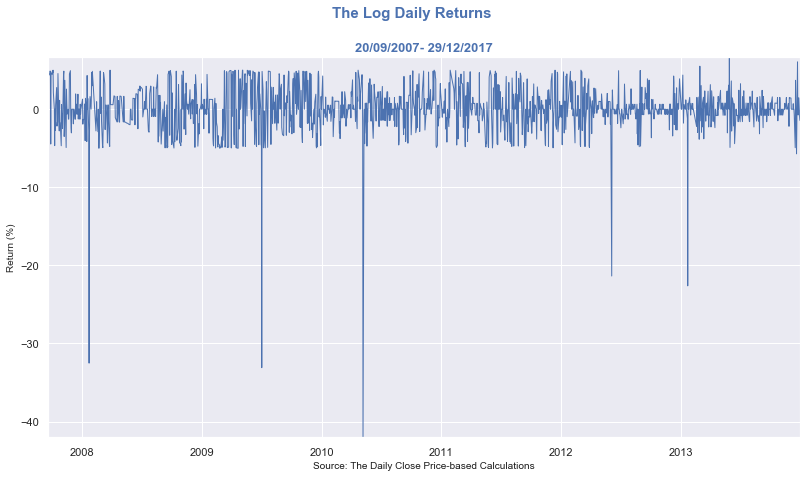

In [17]:
sns.set()
fig=plt.figure(figsize=(12,7))
plt.plot(daily_return.Return['2007':'2013'],LineWidth=1)
plt.autoscale(enable=True,axis='both',tight=True)
#plt.grid(linestyle=':',which='both',linewidth=2)
fig.suptitle('The Log Daily Returns', fontsize=15,fontweight='bold'
             ,color='b')
plt.title('20/09/2007- 29/12/2017',fontsize=13,fontweight='bold',
          color='b')
plt.ylabel('Return (%)',fontsize=10)
plt.xlabel('Source: The Daily Close Price-based Calculations',fontsize=10,fontweight='normal',color='k')

# Modelling GARCH model

$$\text{Mean equation:}$$
$$r_{t}=\mu + \epsilon_{t}$$

$$\text{Volatility equation:}$$
$$\sigma^{2}_{t}= \omega + \alpha \epsilon^{2}_{t} + \beta\sigma^{2}_{t-1}$$

$$\text{Volatility equation:}$$

$$\epsilon_{t}= \sigma_{t} e_{t}$$

$$e_{t} \sim N(0,1)$$


In [ ]:
for row in daily_return.index: 
    print(row)

In [51]:
#garch = arch_model(daily_return,mean='AR',lags=5,
 #                  vol='GARCH',dist='studentst',
  #              p=1, o=0, q=1)
garch = arch_model(daily_return,vol='Garch', p=1, o=0, q=1, dist='skewt')
results_garch = garch.fit(last_obs='2016-12-30', update_freq=1,disp='on')
print(results_garch.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 5068.890242486492
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5067.671385363987
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5038.111895249387
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5010.58977658058
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4998.378529052037
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4991.849020135816
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4987.496930863363
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4983.935149485995
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4980.919860706174
Iteration:     10,   Func. Count:     91,   Neg. LLF: 4974.072712764492
Iteration:     11,   Func. Count:     99,   Neg. LLF: 4966.567924462271
Iteration:     12,   Func. Count:    108,   Neg. LLF: 4966.268381147839
Iteration:     13,   Func. Count:    116,   Neg. LLF: 4966.214551068322
Iteration:     14,   Func. Count:    124,   Neg. LLF: 4966.188072

# Estimating the VaR

we use the model to estimate the VaR


Value-at-Risk (VaR) forecasts from GARCH models depend on the conditional mean, the conditional volatility and the quantile of the standardized residuals,

$$\text{VaR}_{t+1|t}=\mu_{t+1} -\sigma_{t+1|t}q_{\alpha} $$


where $q_{\alpha}$ is the $\alpha$ quantile of the standardized residuals, e.g., 5%.

## Computing the quantiles

The quantiles, $q_{\alpha}$, can be computed using the ppf method of the distribution attached to the model. The quantiles, $q_{\alpha}$, are given below.

In [60]:
quantiles_VaRgarch = garch.distribution.ppf([0.01, 0.05], results_garch.params[-2:])
print(Bold+'The quantiles at 1% and 5% are given as follows'+End)
print(quantiles_VaRgarch)

The quantiles at 1% and 5% are given as follows
[-2.64190619 -1.52673395]


## Computing the conditional mean and volatilitie

In [94]:
forecasts_VaRgarch = results_garch.forecast(start='2017-01-03')
cond_mean_VaRgarch = forecasts_VaRgarch.mean['2017':]
cond_var_VaRgarch = forecasts_VaRgarch.variance['2017':]


## Computing the Value-At-Risk (VaR)

In [104]:
value_at_risk = -cond_mean_VaRgarch.values - np.sqrt(cond_var_VaRgarch).values * quantiles_VaRgarch[None, :]

value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var_VaRgarch.index)

value_at_risk.head(5)

,1%,5%
DATE,,
2017-01-03,3.738101,2.157332
2017-01-04,3.901279,2.251631
2017-01-05,3.656464,2.110154
2017-01-06,4.731917,2.731649
2017-01-09,4.048962,2.336975


# Visualizing the VaR vs actual values
## Picking actual data

In [102]:
rets_2017= daily_return['2017':].copy()
rets_2017.name = 'Return'
rets_2017.head(5)

,Return
DATE,
2017-01-03,-0.952381
2017-01-04,1.081731
2017-01-05,0.594530
2017-01-06,1.891253
2017-01-09,0.232019


## Plotting

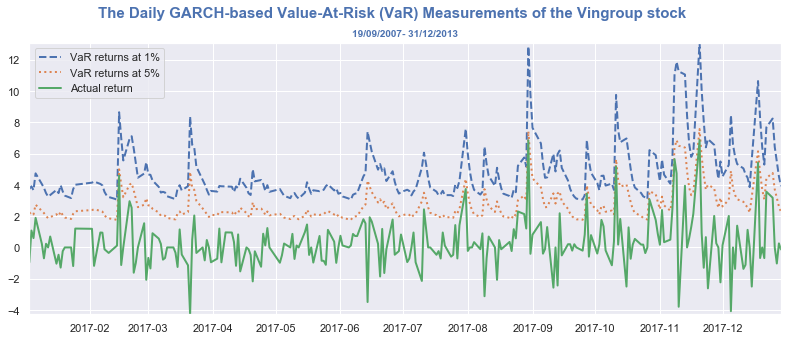

In [110]:
fig=plt.figure(figsize=(12,5))
plt.plot(value_at_risk['1%'] ,LineWidth=2,
         linestyle='--',label='VaR returns at 1%')
plt.plot(value_at_risk['5%'] ,LineWidth=2,
         linestyle=':',label='VaR returns at 5%')
plt.plot(rets_2017['Return'] ,LineWidth=2,
         linestyle='-',label='Actual return')
plt.suptitle('The Daily GARCH-based Value-At-Risk (VaR) Measurements of the Vingroup stock', 
             fontsize=15,fontweight='bold',
            color='b')
plt.title('19/09/2007- 31/12/2013',fontsize=10,
          fontweight='bold',color='b')
plt.autoscale(enable=True,axis='both',tight=True)
plt.legend()